In [1]:
import torch 
import torch.nn as nn       
import config         # 超参数的库
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.optim as optim

from torch.utils.data import DataLoader # 对数据集进行minibatch操作
from torch.utils.tensorboard import SummaryWriter # 将训练进程写入tensorboard，方便可视化
from model import Generator
from model import Discriminator


import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from tqdm import tqdm

### 1.数据集加载

In [2]:
# 首先将数据传入时，要将其变成tensor，且取值是[-1,1]
transforms = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

In [3]:
# 加载数据集
dataset = datasets.ImageFolder(root=config.Data_root, transform=transforms)

# 对数据集进行minibatch的操作
loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKER)

In [4]:
# 接下来对minibatch做一个可视化
real_batch = next(iter(loader))
print(real_batch[0].shape)

torch.Size([128, 3, 64, 64])


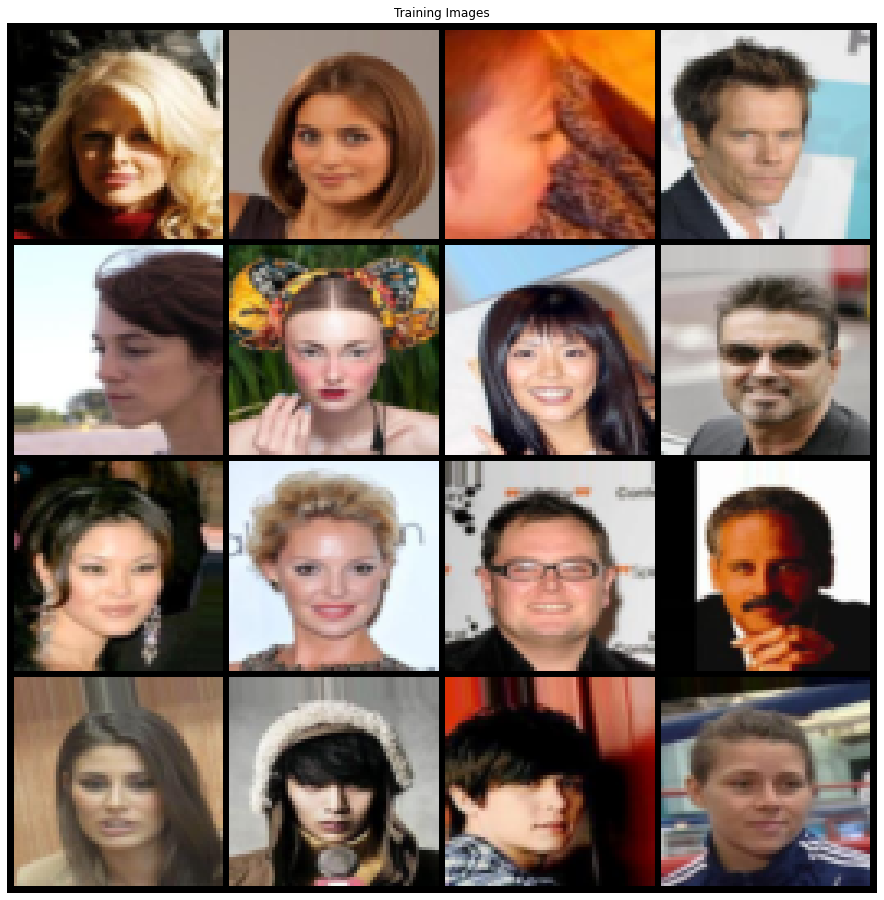

In [5]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(config.DEVICE)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

### tesorboard 可视化函数

In [6]:
def plot_to_tensorboard(writer, loss_disc, loss_gen, real, fake, tensorboard_step):
    
    writer.add_scalar("Loss Disc", loss_disc, global_step=tensorboard_step)
    writer.add_scalar("Loss Gen", loss_gen, global_step=tensorboard_step)

    with torch.no_grad():
        
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
        
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

### 对模型进行初始化

In [7]:
# 对生成器与判别器中的参数进行初始化的函数
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [9]:
# 生成器与判别器
gen = Generator(config.Z_DIM, 3, 64).to(config.DEVICE)
disc = Discriminator(3,64).to(config.DEVICE)

# 对生成器与判别器进行参数初始化
initialize_weights(gen)
initialize_weights(disc)

# 优化器
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5,0.999))
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5,0.999))

# 损失函数（BCE 交叉熵损失）
criterion = nn.BCELoss()

# tensorboard可视化
writer = SummaryWriter("logs")
tensorboard_step = 0

fixed_noise = torch.randn(config.BATCH_SIZE,config.Z_DIM,1,1).to(config.DEVICE)

gen.train();
disc.train();

### 训练

In [11]:
for epoch in range(config.NUM_EPOCH):
    loop = tqdm(loader, leave=True)
    
    for batch_idx, (real ,_) in enumerate(loop):
        
        real = real.to(config.DEVICE)
        noise = torch.randn(config.BATCH_SIZE,config.Z_DIM,1,1).to(config.DEVICE)
        
        # 先训练判别器   
        fake = gen(noise)
        disc_fake = disc(fake.detach()).view(-1)
        disc_real = disc(real).view(-1)
            
        loss_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
        loss_real = criterion(disc_real,torch.ones_like(disc_real))
            
        loss_disc = (loss_fake + loss_real)/2
        
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()
        
        # 训练生成器   
        disc_fake = disc(fake).reshape(-1)
        loss_gen = criterion(disc_fake,torch.ones_like(disc_fake))
            
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        
        if batch_idx % 500 == 0:
            
            with torch.no_grad():
                fixed_fakes = gen(fixed_noise) * 0.5 + 0.5
            
            plot_to_tensorboard(writer,loss_disc.item(), loss_gen.item(),real.detach(),fixed_fakes.detach(),tensorboard_step)
            
            tensorboard_step += 1

        loop.set_postfix(
            
            loss_disc_real = loss_real.item(),
            loss_disc_fake = loss_fake.item(),
            loss_disc = loss_disc.item(),
            loss_gen = loss_gen.item()
        )

100%|██| 1583/1583 [05:03<00:00,  5.21it/s, loss_disc=0.625, loss_disc_fake=0.627, loss_disc_real=0.622, loss_gen=1.13]
